In [ ]:
!pip install datasets
!pip install transformers
!pip install allennlp_models

# Only needed on Colab due to bug in the installed version of accelerate and old version of urllib3
!pip uninstall accelerate
!pip install accelerate
!pip install --upgrade urllib3

In [ ]:
import os
import urllib.request
from tqdm import tqdm
import pandas as pd
from typing import List, Callable, Dict
import numpy as np
from transformers import AutoTokenizer, EncoderDecoderModel, Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import load_dataset,load_metric
import transformers
import os
import torch
from sklearn.model_selection import train_test_split
import matplotlib as plt
from transformers import DataCollatorForSeq2Seq
from allennlp_models.rc.tools import squad
from statistics import mean
from google.colab import files
from hashlib import new
import json

# Data Pre-Processing

In [ ]:
def prev_qa(df, prev):

    history_mask = df["text"] == df["text"].shift(prev)
    history_series = df["history"].astype(str) + ' ' + df["question"].shift(prev) + ' ' + df["answer"].shift(prev) + '.'
    df["history"] = np.where(history_mask, history_series, df["history"])

    return df,history_mask.sum()

def crate_conv_history(df):
  df['history'] = ""

  for i in range(1,4):
    df, count = prev_qa(df,i)

    if count == 0:
      break;

  return df


Axes(0.125,0.11;0.775x0.77)


,text,question,answer,source,history,conv_hist
0,"The Vatican Apostolic Library (), more commonl...",When was the Vat formally opened?,It was formally established in 1475,wikipedia,,When was the Vat formally opened?
1,"The Vatican Apostolic Library (), more commonl...",what is the library for?,research,wikipedia,When was the Vat formally opened? It was form...,what is the library for? When was the Vat form...
2,"The Vatican Apostolic Library (), more commonl...",for what subjects?,"history, and law",wikipedia,what is the library for? research. When was t...,for what subjects? what is the library for? re...
3,"The Vatican Apostolic Library (), more commonl...",and?,"philosophy, science and theology",wikipedia,"for what subjects? history, and law. what is ...","and? for what subjects? history, and law. what..."
4,"The Vatican Apostolic Library (), more commonl...",what was started in 2014?,a project,wikipedia,"and? philosophy, science and theology. for wh...","what was started in 2014? and? philosophy, sci..."


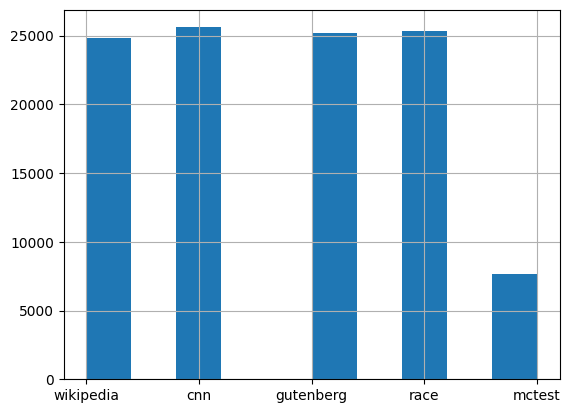

In [ ]:
coqa = pd.read_json('http://downloads.cs.stanford.edu/nlp/data/coqa/coqa-train-v1.0.json')
del coqa["version"]

cols = ["text","question","answer","source"]

comp_list = []
for index, row in coqa.iterrows():
    for i in range(len(row["data"]["questions"])):
        temp_list = []
        temp_list.append(row["data"]["story"])
        temp_list.append(row["data"]["questions"][i]["input_text"])
        temp_list.append(row["data"]["answers"][i]["input_text"])
        temp_list.append(row["data"]["source"])
        comp_list.append(temp_list)

new_df = pd.DataFrame(comp_list, columns=cols)
print(new_df["source"].hist())
new_df = crate_conv_history(new_df)
new_df['conv_hist'] = new_df['question'].str.cat(new_df["history"])

new_df.head()

In [ ]:
# Count the amount of unanswerable questions and remove them
c = 0
for i in range(0,len(new_df)):

  if new_df["answer"][i] == "unknown":
    c = c + 1

for i in range(0,len(new_df)):
  if new_df["answer"][i] == "unknown":
    new_df = new_df.drop(axis=0, index=i)

print("Removed",c, "unanswerable questions")

Removed 1371 unanswerable questions


In [ ]:
random_state = 42 # Seed for reproducibility
new_df = new_df.applymap(lambda x: x.lower() if type(x) == str else x)
new_df = new_df[:10000]
# Split the dataset into trainning set and validation set
texts = new_df['text'].drop_duplicates()
val_text = texts.sample(frac=0.2, random_state = random_state)
val_qa = new_df['text'].isin(val_text)
ds_val = new_df[val_qa]
ds_train = new_df[~val_qa]

# Check that the obtained splits don't contain shared stories (avoid data leakage)
if set(ds_train["text"]).intersection(set(ds_val["text"])) == set():
  print("Correct split!")

  ds_train.to_csv("CoQA_train.csv", index=False)
  ds_val.to_csv("CoQA_val.csv", index=False)

  ds_train = load_dataset('csv', data_files="CoQA_train.csv",split='train')
  ds_val = load_dataset('csv', data_files="CoQA_val.csv",split='train')
else:
  print("Error! Bad split!")

Correct split!


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/download/streaming_download_manager.py:776: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  return pd.read_csv(xopen(filepath_or_buffer, "rb", use_auth_token=use_auth_token), **kwargs)


Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-636d63c4300d8a36/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-e218aad9cb6e641a/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


/usr/local/lib/python3.10/dist-packages/datasets/download/streaming_download_manager.py:776: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  return pd.read_csv(xopen(filepath_or_buffer, "rb", use_auth_token=use_auth_token), **kwargs)


In [ ]:
# Select which model to use
model_checkpoint =  "prajjwal1/bert-tiny"
#model_checkpoint =  "distilroberta-base"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, model_max_length=512)
model = EncoderDecoderModel.from_encoder_decoder_pretrained(model_checkpoint,model_checkpoint)

assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)
pad_on_right = tokenizer.padding_side == "right"

Downloading:   0%|          | 0.00/285 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertLMHeadModel: ['cls.seq_re

In [ ]:
encoder_max_length=512
decoder_max_length=128

def process_data_to_model_inputs(batch):
  # tokenize the inputs and labels
  inputs = tokenizer(batch["text"], batch["question"], padding="max_length", truncation=True, max_length=encoder_max_length, return_tensors="pt")
  outputs = tokenizer(batch["answer"], padding="max_length", truncation=True, max_length=decoder_max_length)

  batch["input_ids"] = inputs.input_ids
  batch["attention_mask"] = inputs.attention_mask
  batch["decoder_input_ids"] = outputs.input_ids
  batch["decoder_attention_mask"] = outputs.attention_mask
  batch["labels"] = outputs.input_ids.copy()
  batch["labels"] = [[-100 if token == tokenizer.pad_token_id else token for token in labels] for labels in batch["labels"]]

  return batch

def process_data_with_history_to_model_inputs(batch):
  # tokenize the inputs and labels
  inputs = tokenizer(batch["text"],batch['conv_hist'], padding="max_length", truncation=True, max_length=encoder_max_length, return_tensors="pt")
  outputs = tokenizer(batch["answer"], padding="max_length", truncation=True, max_length=decoder_max_length)

  batch["input_ids"] = inputs.input_ids
  batch["attention_mask"] = inputs.attention_mask
  batch["decoder_input_ids"] = outputs.input_ids
  batch["decoder_attention_mask"] = outputs.attention_mask
  batch["labels"] = outputs.input_ids.copy()
  batch["labels"] = [[-100 if token == tokenizer.pad_token_id else token for token in labels] for labels in batch["labels"]]

  return batch

In [ ]:
CONV_TRAIN = False

In [ ]:
if CONV_TRAIN:
  tk_train = ds_train.map(process_data_with_history_to_model_inputs, batched=True, remove_columns=["text", "question", "answer", "history", "source", "conv_hist"])

  tk_val = ds_val.map(process_data_with_history_to_model_inputs, batched=True,remove_columns=["text", "question", "answer", "history", "source", "conv_hist"])
else:
  tk_train = ds_train.map(process_data_to_model_inputs,batched=True,remove_columns=["text", "question", "answer", "history", "source", "conv_hist"])

  tk_val = ds_val.map(process_data_to_model_inputs,batched=True,remove_columns=["text", "question", "answer", "history", "source", "conv_hist"])


Map:   0%|          | 0/8031 [00:00<?, ? examples/s]

Map:   0%|          | 0/1969 [00:00<?, ? examples/s]

# Metrics for evaluation during training

In [ ]:
def metrics(pred):
  squad_f1 = []
  labels_ids = pred.label_ids
  pred_ids = pred.predictions

  pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
  labels_ids[labels_ids == -100] = tokenizer.pad_token_id
  label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)


  for i in range(0,len(pred_str)-1):
    squad_f1.append(squad.compute_f1(a_pred=pred_str[i], a_gold=label_str[i]))

  return {"squad_f1": mean(squad_f1)}

# Training

In [ ]:
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.eos_token_id = tokenizer.sep_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = model.config.encoder.vocab_size
model.config.max_length = 512
model.config.min_length = 56
model.config.no_repeat_ngram_size = 3
model.config.early_stopping = True
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [ ]:
batch_size = 8
os.environ["WANDB_DISABLED"] = "true"

args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy = "epoch",
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    num_train_epochs = 3,
    push_to_hub = False,
    report_to = None,
    output_dir = "./",
    seed = 42  # train seeds 42,2022,1337
)

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, return_tensors="pt")

In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    compute_metrics=metrics,
    train_dataset=tk_train,
    eval_dataset=tk_val,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

trainer.train()

In [ ]:
d = trainer.state.log_history
file = open("log_history_tb42.json", "w")
json.dump(d, file)
file.close()

In [ ]:
trainer.save_model("./trained_model")
model.from_pretrained("./trained_model")

# Evaluation

In [ ]:
coqa_test = pd.read_json('http://downloads.cs.stanford.edu/nlp/data/coqa/coqa-dev-v1.0.json')
del coqa_test["version"]
cols = ["id", "text","question","answer","source"]

comp_list = []
for index, row in coqa.iterrows():
    for i in range(len(row["data"]["questions"])):
        temp_list = []
        temp_list.append(i)
        temp_list.append(row["data"]["story"])
        temp_list.append(row["data"]["questions"][i]["input_text"])
        temp_list.append(row["data"]["answers"][i]["input_text"])
        temp_list.append(row["data"]["source"])
        comp_list.append(temp_list)
ds_test = pd.DataFrame(comp_list, columns=cols)
ds_test = ds_test.sort_values("source", ascending=False)
ds_test = ds_test.head(10000)

ds_test.to_csv("CoQA_test.csv", index=False)
ds_test = load_dataset("csv", data_files="CoQA_test.csv",split='train')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/download/streaming_download_manager.py:776: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  return pd.read_csv(xopen(filepath_or_buffer, "rb", use_auth_token=use_auth_token), **kwargs)


Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-7e7eca1d65959f83/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


In [ ]:
def evaluation(batch):
    # cut off at max length 512
    inputs = tokenizer(batch["text"], batch["question"], padding="max_length", truncation=True, max_length=encoder_max_length, return_tensors="pt")
    input_ids = inputs.input_ids.to("cuda")
    attention_mask = inputs.attention_mask.to("cuda")

    model.eval()
    outputs = model.generate(input_ids, attention_mask=attention_mask, max_new_tokens=128, decoder_start_token_id=model.config.decoder.pad_token_id)
    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    batch["pred_answer"] = output_str

    return batch

In [ ]:
batch_size = 8
outcomes = ds_test.map(evaluation, batched=True, batch_size=batch_size, remove_columns=["text", "question"])

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
outcomes = pd.DataFrame(outcomes)

In [ ]:
cols = ["answer","pred_answer","source"]
comp_list = []
for i in range(0, len(outcomes)-1):
  temp_list = []
  temp_list.append(outcomes['answer'][i])
  temp_list.append(outcomes['pred_answer'][i])
  temp_list.append(outcomes['source'][i])
  comp_list.append(temp_list)

answers = pd.DataFrame(comp_list,columns=cols)
results = []

for i in range(0, len(outcomes)-1):
  predictions = answers["pred_answer"][i]
  references = answers["answer"][i]
  results.append(squad.compute_f1(a_pred=predictions, a_gold=references))

answers["score"] = results
print("mean F1 score: ", mean(results))

mean F1 score:  0.00012669231354137377


In [ ]:
# Examin the 5 best and the 5 worst outputs
answers.sort_values("score", ascending=False)

answers.head()

,answer,pred_answer,source,score
0,It was formally established in 1475,served served served worked worked worked serv...,wikipedia,0.0
1,the Japanese created a settlement at the south...,served served served worked worked worked serv...,wikipedia,0.0
2,Nobuhiro's descendants became the rulers of th...,served served served worked worked worked serv...,wikipedia,0.0
3,"Takeda Nobuhiro killed the Ainu leader, Kosham...",served served served worked worked worked serv...,wikipedia,0.0
4,Japanese created a settlement at the south of ...,served served served worked worked worked serv...,wikipedia,0.0


In [ ]:
answers.tail()

,answer,pred_answer,source,score
9994,5.75 million,served served served worked worked worked work...,wikipedia,0.0
9995,yes,served served served worked worked worked work...,wikipedia,0.0
9996,yes,served served served worked worked worked work...,wikipedia,0.0
9997,in the 17th century,served served served worked worked worked work...,wikipedia,0.0
9998,Greenland and Iceland,served served served worked worked worked work...,wikipedia,0.0


In [ ]:
!zip -r /content/trained_model_tb42.zip /content/trained_model/
files.download("/content/trained_model_tb42.zip")

  adding: content/trained_model/ (stored 0%)
  adding: content/trained_model/vocab.txt (deflated 53%)
  adding: content/trained_model/tokenizer.json (deflated 71%)
  adding: content/trained_model/tokenizer_config.json (deflated 44%)
  adding: content/trained_model/training_args.bin (deflated 48%)
  adding: content/trained_model/pytorch_model.bin (deflated 7%)
  adding: content/trained_model/special_tokens_map.json (deflated 42%)
  adding: content/trained_model/config.json (deflated 81%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>